<a href="https://colab.research.google.com/github/deeabiv/Luna-18/blob/main/custsegment_04-Copy7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans, MeanShift, estimate_bandwidth
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split
!pip install kmodes
from kmodes.kprototypes import KPrototypes
from kmodes.kmodes import KModes

from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
!pip install kneed
from kneed import KneeLocator

nK = 12                     # initial guess: clusters
RNDN = 42                   # random state

from tqdm import tqdm
import sys
import warnings
warnings.filterwarnings("ignore")


%matplotlib inline
pd.set_option("display.precision",2)
np.set_printoptions(precision=3, suppress=True)
pd.options.display.float_format = '{:.3f}'.format

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [13]:
data = pd.read_csv('https://raw.githubusercontent.com/deeabiv/Luna-18/main/set-de-date.csv',sep=';',skiprows=1, usecols=range(22))
#data = data.drop('w')
data_original = pd.read_csv('https://raw.githubusercontent.com/deeabiv/Luna-18/main/set-de-date.csv',sep=';',skiprows=0, usecols=range(22))
data_original = data_original.drop([0, 0])
data_original = data_original.reset_index(drop=True)
data_original
#df.reset_index(drop=True, inplace=True)

,ID,Esti...,Care este varsta ta in ani impliniti?,Locuiesti in mediul...,in ce judet locuiesti?,Cu ce frecventa te uiti la televizor? *Raspuns unic.*,Care este ultima forma de invatamant pe care ai absolvit-o?,Care este starea ta civila?,Ai copii?,Cati copii ai?,...,incadreaza venitul tau total net in una dintre categoriile urmatoare:,in ce masura iti place sau nu aceasta reclama?,"si in ce masura simti ca ti se adreseaza/ se potriveste pentru tine personal, serviciul promovat?",Voi contracta serviciile Brand 3,Cum consideri pretul de *24.6 Ron (5 euro) / luna* pentru *un abonament lunar al serviciului de streaming al Brand 3?,Cum consideri pretul de *39.4 Ron (8 euro) / luna* pentru un abonament lunar de *daca ar include si continut suplimentar?*,"Folosind o scala de la 0 la 10, in ce masura ai recomanda familiei, prietenilor, cunoscutilor *furnizorul de televiziune pe care il folosesti in prezent*?",Intentionezi ca in urmatoarele 6 luni sa schimbi furnizorul actual de servicii de televiziune? *Raspuns unic.*,"Pe langa serviciile de televiziune traditionala, in ce masura iei in considerare contractarea serviciilor de televiziune online sau streaming? *Raspuns unic.*","Care *cel mai important motiv* pentru care *nu te uiti* la televizor? (Alege un singurul motiv, cel care primeaza in decizia de a nu te uita la TV.)"
0,1,Barbat,31,Urban,BUCURESTI,Zilnic,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,,,NaN,NaN,NaN,NaN
1,2,Barbat,37,Urban,PRAHOVA,Zilnic,"Studii postuniversitare (master, doctorat)",Necasatorit/a,Nu,NaN,...,1.001 - 1.700 lei,Asa si-asa,Asa si-asa,"Poate da, poate nu",Ieftin,Scump,9,Cu siguranta NU il voi schimba in urmatoarele ...,Probabil voi contracta servicii de TV online s...,"As vrea sa ma uit, dar nu am timp"
2,3,Barbat,45,Rural,ARAD,Zilnic,Facultate (3-5 ani),Uniune consensuala/ Casatorit/a,Da,1 copil,...,Refuz sa raspund,Nu-mi place deloc,Nu mi se potriveste deloc,Cu siguranta nu,Scump,Prea scump,8,Cu siguranta il voi schimba in urmatoarele 6 luni,Probabil NU voi contracta servicii de TV onlin...,"As vrea sa ma uit, dar nu am timp"
3,4,Barbat,42,Urban,GALATI,Zilnic,Gimnaziu (8 clase),Divortat/a / Separat/a,Da,1 copil,...,Refuz sa raspund,Asa si-asa,Nu mi se potriveste deloc,Cu siguranta da,Scump,Prea scump,10,Cu siguranta NU il voi schimba in urmatoarele ...,Cu siguranta voi contracta servicii de TV onli...,"As vrea sa ma uit, dar nu am timp"
4,5,Barbat,44,Urban,PRAHOVA,Zilnic,Treapta 1 de liceu (10 clase),Uniune consensuala/ Casatorit/a,Da,1 copil,...,1.001 - 1.700 lei,Asa si-asa,Nu prea mi se potriveste,"Poate da, poate nu",Acceptabil,Scump,7,Probabil il voi schimba in urmatoarele 6 luni,"Poate voi contracta, poate nu",Reclamele
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4495,4496,Barbat,18,Rural,SUCEAVA,Zilnic,Treapta 1 de liceu (10 clase),Necasatorit/a,Nu,NaN,...,Refuz sa raspund,Asa si-asa,Nu mi se potriveste deloc,Probabil da,Ieftin,Acceptabil,9,Cu siguranta NU il voi schimba in urmatoarele ...,Cu siguranta NU voi contracta servicii de TV o...,"As vrea sa ma uit, dar nu am timp"
4496,4497,Femeie,27,Rural,VASLUI,Zilnic,Liceu (12 clase),Refuz sa raspund,Nu,NaN,...,2.001 - 3.000 lei,Asa si-asa,Asa si-asa,"Poate da, poate nu",Acceptabil,Scump,10,Cu siguranta NU il voi schimba in urmatoarele ...,Probabil NU voi contracta servicii de TV onlin...,"As vrea sa ma uit, dar nu am timp"
4497,4498,Barbat,33,Urban,BRASOV,Zilnic,Liceu (12 clase),Uniune consensuala/ Casatorit/a,Da,3 copii,...,751 - 1.000 lei,imi place mult,Mi se potriveste foarte bine,Cu siguranta da,Scump,Prea scump,8,Cu siguranta NU il voi schimba in urmatoarele ...,Cu siguranta voi contracta servicii de TV onli...,Prefer surse mai moderne de divertisment (inte...
4498,4499,Femeie,41,Urban,HARGHITA,NaN,"Studii postuniversitare (master, doctorat)",Uniune consensuala/ Casatorit/a,Nu,NaN,...,Nu realizez venituri,imi place mult,Mi se potriveste foarte bine,Probabil da,NaN,NaN,10,Cu siguranta NU il voi schimba in urmato

In [14]:
data

,ID,sex,varsta,mediu,judet,frecventa_privit_tv,ultima_forma_invatamant,stare_civila,cu_copii,nr_copii,...,venit_net,atractie_reclama,masura_potrivire_serviciu,voi_contracta_serviciile,cum_consideri_pretul_1,cum_consideri_pretul_2,masura_recomandare_serviciu_folosit,doresti_schimbare_furnizor,consideri_servicii_tv_online,motiv_nu_te_uiti_la_tv
0,1,Barbat,31.000,Urban,BUCURESTI,Zilnic,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,,,NaN,NaN,NaN,NaN
1,2,Barbat,37.000,Urban,PRAHOVA,Zilnic,"Studii postuniversitare (master, doctorat)",Necasatorit/a,Nu,NaN,...,1.001 - 1.700 lei,Asa si-asa,Asa si-asa,"Poate da, poate nu",Ieftin,Scump,9.000,Cu siguranta NU il voi schimba in urmatoarele ...,Probabil voi contracta servicii de TV online s...,"As vrea sa ma uit, dar nu am timp"
2,3,Barbat,45.000,Rural,ARAD,Zilnic,Facultate (3-5 ani),Uniune consensuala/ Casatorit/a,Da,1 copil,...,Refuz sa raspund,Nu-mi place deloc,Nu mi se potriveste deloc,Cu siguranta nu,Scump,Prea scump,8.000,Cu siguranta il voi schimba in urmatoarele 6 luni,Probabil NU voi contracta servicii de TV onlin...,"As vrea sa ma uit, dar nu am timp"
3,4,Barbat,42.000,Urban,GALATI,Zilnic,Gimnaziu (8 clase),Divortat/a / Separat/a,Da,1 copil,...,Refuz sa raspund,Asa si-asa,Nu mi se potriveste deloc,Cu siguranta da,Scump,Prea scump,10.000,Cu siguranta NU il voi schimba in urmatoarele ...,Cu siguranta voi contracta servicii de TV onli...,"As vrea sa ma uit, dar nu am timp"
4,5,Barbat,44.000,Urban,PRAHOVA,Zilnic,Treapta 1 de liceu (10 clase),Uniune consensuala/ Casatorit/a,Da,1 copil,...,1.001 - 1.700 lei,Asa si-asa,Nu prea mi se potriveste,"Poate da, poate nu",Acceptabil,Scump,7.000,Probabil il voi schimba in urmatoarele 6 luni,"Poate voi contracta, poate nu",Reclamele
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4495,4496,Barbat,18.000,Rural,SUCEAVA,Zilnic,Treapta 1 de liceu (10 clase),Necasatorit/a,Nu,NaN,...,Refuz sa raspund,Asa si-asa,Nu mi se potriveste deloc,Probabil da,Ieftin,Acceptabil,9.000,Cu siguranta NU il voi schimba in urmatoarele ...,Cu siguranta NU voi contracta servicii de TV o...,"As vrea sa ma uit, dar nu am timp"
4496,4497,Femeie,27.000,Rural,VASLUI,Zilnic,Liceu (12 clase),Refuz sa raspund,Nu,NaN,...,2.001 - 3.000 lei,Asa si-asa,Asa si-asa,"Poate da, poate nu",Acceptabil,Scump,10.000,Cu siguranta NU il voi schimba in urmatoarele ...,Probabil NU voi contracta servicii de TV onlin...,"As vrea sa ma uit, dar nu am timp"
4497,4498,Barbat,33.000,Urban,BRASOV,Zilnic,Liceu (12 clase),Uniune consensuala/ Casatorit/a,Da,3 copii,...,751 - 1.000 lei,imi place mult,Mi se potriveste foarte bine,Cu siguranta da,Scump,Prea scump,8.000,Cu siguranta NU il voi schimba in urmatoarele ...,Cu siguranta voi contracta servicii de TV onli...,Prefer surse mai moderne de divertisment (inte...
4498,4499,Femeie,41.000,Urban,HARGHITA,NaN,"Studii postuniversitare (master, doctorat)",Uniune consensuala/ Casatorit/a,Nu,NaN,...,Nu realizez venituri,imi place mult,Mi se potriveste foarte bine,Probabil da,NaN,NaN,10.000,Cu siguranta NU il voi schimba in urmatoarele ...,"Poate voi contracta, poate nu","As vrea sa ma uit, dar nu am timp"


In [15]:
# any missing values?
data.isnull().values.any()

#data.info()



True

In [16]:
# elemente unice
print(data.select_dtypes("object").nunique())

# variabile numerice
data.select_dtypes(exclude='object').describe()

sex                              2
mediu                            2
judet                           42
frecventa_privit_tv              9
ultima_forma_invatamant          8
stare_civila                     5
cu_copii                         2
nr_copii                         6
ocupatie                         9
venit_net                       12
atractie_reclama                 5
masura_potrivire_serviciu        5
voi_contracta_serviciile         5
cum_consideri_pretul_1           6
cum_consideri_pretul_2           6
doresti_schimbare_furnizor       5
consideri_servicii_tv_online     5
motiv_nu_te_uiti_la_tv           5
dtype: int64


,ID,varsta,persoane_intretinere,masura_recomandare_serviciu_folosit
count,4500.000,4436.000,4499.000,4314.000
mean,2250.500,497709.753,2.440,8.896
std,1299.182,19135127.759,1.553,1.588
min,1.000,15.000,0.000,0.000
25%,1125.750,33.000,1.000,8.000
50%,2250.500,41.000,2.000,10.000
75%,3375.250,50.000,3.000,10.000
max,4500.000,751498874.000,11.000,10.000


In [17]:
categorical_columns = ['sex','mediu','judet','frecventa_privit_tv','ultima_forma_invatamant','stare_civila',
                       'cu_copii','nr_copii','ocupatie','venit_net','atractie_reclama',
                       'masura_potrivire_serviciu','voi_contracta_serviciile','cum_consideri_pretul_1','cum_consideri_pretul_2',
                      'masura_recomandare_serviciu_folosit','doresti_schimbare_furnizor','consideri_servicii_tv_online',
                       'motiv_nu_te_uiti_la_tv']
def show_column_options(df):
    print('Valori coloane:')
    cols = df.columns
    for col in cols:
        print(col,':',df[col].unique())

show_column_options(data[categorical_columns])

Valori coloane:
sex : ['Barbat' 'Femeie' nan]
mediu : ['Urban' 'Rural' nan]
judet : ['BUCURESTI' 'PRAHOVA' 'ARAD' 'GALATI' 'MURES' 'BOTOSANI' 'COVASNA'
 'CONSTANTA' 'DOLJ' 'OLT' 'IASI' 'BUZAU' 'HUNEDOARA' 'GORJ' 'CLUJ' 'NEAMT'
 'SALAJ' 'BIHOR' 'SUCEAVA' 'HARGHITA' 'IALOMITA' 'TIMIS' 'CARAS-SEVERIN'
 'SATU MARE' 'BRAILA' 'ILFOV' 'MEHEDINTI' 'BACAU' 'ARGES' 'BRASOV' 'SIBIU'
 'BISTRITA-NASAUD' 'CALARASI' 'VALCEA' 'VASLUI' 'TELEORMAN' 'ALBA'
 'DAMBOVITA' 'MARAMURES' 'TULCEA' nan 'VRANCEA' 'GIURGIU']
frecventa_privit_tv : ['Zilnic' 'De 2-3 ori pe saptamana' 'De 4-5 ori pe saptamana'
 'Chiar daca am televizor, nu ma uit niciodata' 'O data pe saptamana' nan
 'O data la cateva luni sau mai rar' 'De 2-3 ori pe luna' 'O data pe luna'
 'Nu am televizor']
ultima_forma_invatamant : [nan 'Studii postuniversitare (master, doctorat)' 'Facultate (3-5 ani)'
 'Gimnaziu (8 clase)' 'Treapta 1 de liceu (10 clase)' 'Liceu (12 clase)'
 'Refuz sa raspund' 'Fara studii' 'scoala primara (4 clase)']
stare_civila 

In [18]:
data["mediu"].value_counts()

Urban    2670
Rural    1739
Name: mediu, dtype: int64

In [19]:
venit_net = {"venit_net":     {"Nu realizez venituri": "Sub 1700 lei","Sub 750 lei": "Sub 1700 lei","751 - 1.000 lei": "Sub 1700 lei",
                               "1.001 - 1.700 lei": "Sub 1700 lei", "1.701 - 2.000 lei": "1.701 - 3.000 lei",
                               "2.001 - 3.000 lei": "1.701 - 3.000 lei","3.001 - 4.000 lei": "3.001 - 5.000 lei",
                               "4.001 - 5.000 lei": "3.001 - 5.000 lei","5.001 - 6.500 lei":"> 5000 lei","> 8000 lei":"> 5000 lei","6.501 - 8.000 lei": "> 5000 lei"}
                }
data = data.replace(venit_net)
data = data[data["venit_net"] != 'Refuz sa raspund']
data["venit_net"].value_counts()

Sub 1700 lei         1861
1.701 - 3.000 lei    1458
3.001 - 5.000 lei     590
> 5000 lei            196
Name: venit_net, dtype: int64

In [20]:
from collections import Counter
def cumulatively_categorise(column,threshold=0.75,return_categories_list=True):
  #Find the threshold value using the percentage and number of instances in the column
  threshold_value=int(threshold*len(column))
  #Initialise an empty list for our new minimised categories
  categories_list=[]
  #Initialise a variable to calculate the sum of frequencies
  s=0
  #Create a counter dictionary of the form unique_value: frequency
  counts=Counter(column)

  #Loop through the category name and its corresponding frequency after sorting the categories by descending order of frequency
  for i,j in counts.most_common():
    #Add the frequency to the global sum
    s+=dict(counts)[i]
    #Append the category name to the list
    categories_list.append(i)
    #Check if the global sum has reached the threshold value, if so break the loop
    if s>=threshold_value:
      break
  #Append the category Other to the list
  categories_list.append('Altele')

  #Replace all instances not in our new categories by Other  
  new_column=column.apply(lambda x: x if x in categories_list else 'Altele')

  #Return transformed column and unique values if return_categories=True
  if(return_categories_list):
    return new_column,categories_list
  #Return only the transformed column if return_categories=False
  else:
    return new_column

#Call the function with a default threshold of 75%
transformed_column,new_category_list=cumulatively_categorise(data['ultima_forma_invatamant'],0.75,return_categories_list=True)
print(new_category_list)
transformed_column,new_category_list=cumulatively_categorise(data['atractie_reclama'],0.65,return_categories_list=True)
print(new_category_list)

['Liceu (12 clase)', 'Facultate (3-5 ani)', 'Treapta 1 de liceu (10 clase)', 'Altele']
['Asa si-asa', 'imi place mult', 'Altele']


In [21]:
data.replace(r'^\s*$', np.nan, regex=True)
data.fillna(data.mode().iloc[0]) ## convert df to a series
#data = data.fillna(data['atractie_reclama'].value_counts().index[0])
data = data.apply(lambda x:x.fillna(x.value_counts().index[0]))
#completare valori nule cu cel mai frecvent raspuns pe fiecare coloana
#data.dropna(inplace=True)
 
data_original.replace(r'^\s*$', np.nan, regex=True)
data_original.fillna(data_original.mode().iloc[0]) ## convert df to a series
data_original = data_original.apply(lambda x:x.fillna(x.value_counts().index[0]))

#data_original.dropna(inplace=True)
cluster_columns = ['varsta','mediu','atractie_reclama','voi_contracta_serviciile']
data = data[cluster_columns]

#data
data

,varsta,mediu,atractie_reclama,voi_contracta_serviciile
0,31.000,Urban,Asa si-asa,"Poate da, poate nu"
1,37.000,Urban,Asa si-asa,"Poate da, poate nu"
4,44.000,Urban,Asa si-asa,"Poate da, poate nu"
5,32.000,Urban,Asa si-asa,"Poate da, poate nu"
6,43.000,Urban,Nu-mi place deloc,Probabil da
...,...,...,...,...
4493,37.000,Urban,Nu prea-mi place,Mai degraba nu
4494,26.000,Rural,Asa si-asa,Probabil da
4496,27.000,Rural,Asa si-asa,"Poate da, poate nu"
4497,33.000,Urban,imi place mult,Cu siguranta da


In [22]:
data

,varsta,mediu,atractie_reclama,voi_contracta_serviciile
0,31.000,Urban,Asa si-asa,"Poate da, poate nu"
1,37.000,Urban,Asa si-asa,"Poate da, poate nu"
4,44.000,Urban,Asa si-asa,"Poate da, poate nu"
5,32.000,Urban,Asa si-asa,"Poate da, poate nu"
6,43.000,Urban,Nu-mi place deloc,Probabil da
...,...,...,...,...
4493,37.000,Urban,Nu prea-mi place,Mai degraba nu
4494,26.000,Rural,Asa si-asa,Probabil da
4496,27.000,Rural,Asa si-asa,"Poate da, poate nu"
4497,33.000,Urban,imi place mult,Cu siguranta da


In [23]:
data["varsta"].value_counts()

40.000           204
42.000           145
44.000           138
52.000           137
43.000           136
                ... 
90.000             1
77.000             1
732638985.000      1
723517440.000      1
87.000             1
Name: varsta, Length: 74, dtype: int64

In [24]:
import scipy.stats as sp
def remove_outliers(df,columns_to_analyse,threshold = 4):
    z_score = np.abs(sp.zscore(df[columns_to_analyse]))
    df_no_outlier = df.loc[(z_score < threshold).all(axis=1),:].copy()
    print(df_no_outlier.shape)
    return df_no_outlier
numerical_columns=["varsta"]
data = remove_outliers(data,numerical_columns,threshold = 10)

display(data.describe())

(4119, 4)


,varsta
count,4119.000
mean,41.559
std,11.984
min,15.000
25%,33.000
50%,41.000
75%,50.000
max,90.000


In [25]:
data["varsta"].value_counts()

40.000    204
42.000    145
44.000    138
52.000    137
43.000    136
         ... 
90.000      1
82.000      1
81.000      1
83.000      1
87.000      1
Name: varsta, Length: 71, dtype: int64

In [26]:

#dfa1 = data.copy()
#dfa1.tail(2)
data.replace(r'^\s*$', np.nan, regex=True)
data.fillna(data.mode().iloc[0]) 
data.head()
data.dropna(inplace=True)
data
#dfa1.isnull().values.any()

#full_data['varsta_bin'] = pd.cut(full_data['varsta'], [0, 20, 30, 45, 60, 100], 
#                              labels=['0-20', '20-30', '30-45', '45-60','60-100'])

,varsta,mediu,atractie_reclama,voi_contracta_serviciile
0,31.000,Urban,Asa si-asa,"Poate da, poate nu"
1,37.000,Urban,Asa si-asa,"Poate da, poate nu"
4,44.000,Urban,Asa si-asa,"Poate da, poate nu"
5,32.000,Urban,Asa si-asa,"Poate da, poate nu"
6,43.000,Urban,Nu-mi place deloc,Probabil da
...,...,...,...,...
4493,37.000,Urban,Nu prea-mi place,Mai degraba nu
4494,26.000,Rural,Asa si-asa,Probabil da
4496,27.000,Rural,Asa si-asa,"Poate da, poate nu"
4497,33.000,Urban,imi place mult,Cu siguranta da


## A1. Translate Categories to Numerical Variables - kMeans

In [27]:
data_kmeans = data.copy()

In [28]:
# scalarea valorilor numerice
col_num = list(data_kmeans.dtypes[data_kmeans.dtypes == "float64"].index)
if len(col_num) !=0:
    scaler = StandardScaler()
    data_kmeans[col_num] = scaler.fit_transform(data_kmeans[col_num])
    data_kmeans.describe()

In [29]:
# convertirea in coloane numerice
def convert_to_codes(df, col): 
    df[col + "_n"] = df[col].astype("category").cat.codes
    df = df.drop(col, axis=1, inplace=True)
for col in list(data_kmeans.dtypes[data_kmeans.dtypes == np.object].index):
    convert_to_codes(data_kmeans, col)
data_kmeans

,varsta,mediu_n,atractie_reclama_n,voi_contracta_serviciile_n
0,-0.881,1,0,3
1,-0.381,1,0,3
4,0.204,1,0,3
5,-0.798,1,0,3
6,0.120,1,2,4
...,...,...,...,...
4493,-0.381,1,1,2
4494,-1.299,0,0,4
4496,-1.215,0,0,3
4497,-0.714,1,4,0


In [30]:
print(data_kmeans.select_dtypes(exclude="object").nunique())
data_kmeans.describe()

varsta                        71
mediu_n                        2
atractie_reclama_n             5
voi_contracta_serviciile_n     5
dtype: int64


,varsta,mediu_n,atractie_reclama_n,voi_contracta_serviciile_n
count,4119.000,4119.000,4119.000,4119.000
mean,-0.000,0.613,1.526,2.430
std,1.000,0.487,1.646,1.231
min,-2.217,0.000,0.000,0.000
25%,-0.714,0.000,0.000,1.000
50%,-0.047,1.000,1.000,3.000
75%,0.704,1.000,3.000,3.000
max,4.043,1.000,4.000,4.000


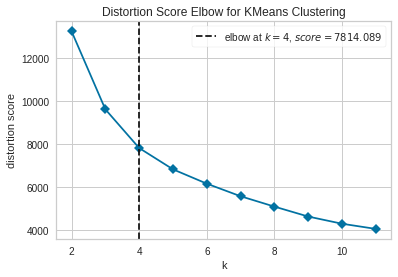

elbow value = optimal k: 4  | elbow score: 7,814.089


In [31]:
# elbow plot using distortion metric

model = KMeans(random_state=RNDN)
visualiser = KElbowVisualizer(
        model, 
        k=(2,nK), 
        metric="distortion",
        locate_elbow=True, 
        timings=False)
visualiser.fit(data_kmeans)      
visualiser.show()  
print("elbow value = optimal k:", f'{visualiser.elbow_value_:.0f}', \
            " | elbow score:", f'{visualiser.elbow_score_:,.3f}')
    

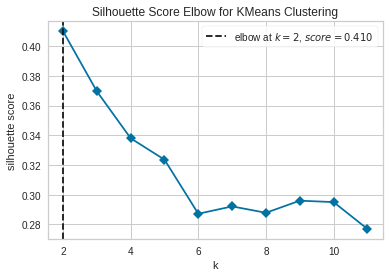

elbow value = optimal k: 2  | elbow score: 0.410


In [32]:
# elbow plot using silhouette metric
visualiser = KElbowVisualizer(
        model, 
        k=(2,nK), 
        metric="silhouette",
        locate_elbow=True, 
        timings=False)
visualiser.fit(data_kmeans)      
visualiser.show()  
print("elbow value = optimal k:", f'{visualiser.elbow_value_:.0f}', \
            " | elbow score:", f'{visualiser.elbow_score_:,.3f}')

inertia scores (sum of squared errors) by number of clusters:
2 : 13,249
3 : 9,615
4 : 7,814
5 : 6,823
6 : 6,156
7 : 5,570
8 : 5,088
9 : 4,625
10 : 4,290
11 : 4,052


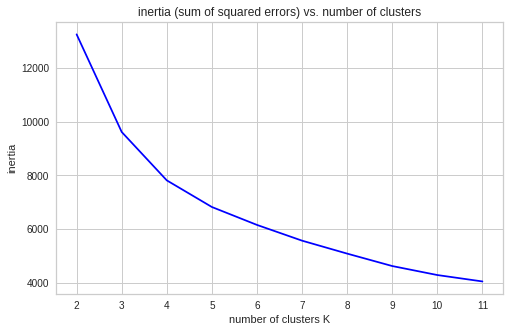

In [33]:
# kmeans: looking for the elbow - compare number of clusters by their inertia scores

# run kMeans for alternative number of clusters k
inertia_scores = [KMeans(
                    n_clusters=k, 
                    init='k-means++', 
                    n_init=10, max_iter=100, random_state=RNDN). \
                    fit(data_kmeans).inertia_ \
                    for k in range(2,nK)]


dict_inertia = dict(zip(range(2,nK), inertia_scores))
print("inertia scores (sum of squared errors) by number of clusters:")
_ = [print(k, ":", f'{v:,.0f}') for k,v in dict_inertia.items()]

# scree plot: look for elbow
plt.figure(figsize=[8,5])
plt.plot(range(2,nK), inertia_scores, color="blue")
plt.title("inertia (sum of squared errors) vs. number of clusters")
plt.xticks(np.arange(2,nK,1.0))
plt.xlabel("number of clusters K")
plt.ylabel("inertia");

In [34]:
# inertia scores: confirm visual clue of elbow plot
# KneeLocator class will detect elbows if curve is convex; if concavem will detect knees
inertia_knee_a3 = KneeLocator(
        range(2,nK), 
        inertia_scores, 
        S=0.1, curve="convex", direction="decreasing")

K_inertia_a3 = inertia_knee_a3.elbow   
print("elbow at k =", f'{K_inertia_a3:.0f} clusters')

elbow at k = 4 clusters


In [35]:
# kMeans: silhouette score
# initial example: silhouette score for 4 clusters
k = 4
model = KMeans(n_clusters=k, random_state=RNDN, verbose=0)
clusters_assigned = model.fit_predict(data_kmeans)
#K_sil_a3 = silhouette_score(data_kmeans, clusters_assigned)
#print("silhouette score for", k, "clusters: " f'{K_sil_a3:.3f}')

In [36]:
# find maximum silhouette score for up to kN clusters
'''sil_scores = [silhouette_score(
                                data_kmeans, 
                                KMeans(n_clusters=k, random_state=RNDN). \
                                fit_predict(data_kmeans)) \
                                for k in tqdm(range(2,nK))]

dict_sil = dict(zip(range(2,nK), sil_scores))
print("silhouette scores:")
_ = [print(k, ":", f'{v:,.3f}') for k,v in dict_sil.items()]
K_sil_a3 = 4 #max(dict_sil, key=dict_sil.get)            # optimal clusters
sil_opt_a3 = dict_sil[K_sil_a3]                       # optimal silhouette score
print("maximum silhouette score for", f'{K_sil_a3:.0f} clusters: ', f'{sil_opt_a3:.3f}')

plt.figure(figsize=[7,5])
plt.plot(range(2,nK), sil_scores, color="red")
plt.title("silhouette scores vs. number of clusters")
plt.xticks(np.arange(2,nK,1))
plt.xlabel("number of clusters K")
plt.ylabel("silhouette score")
plt.show()'''

'sil_scores = [silhouette_score(\n                                data_kmeans, \n                                KMeans(n_clusters=k, random_state=RNDN).                                 fit_predict(data_kmeans))                                 for k in tqdm(range(2,nK))]\n\ndict_sil = dict(zip(range(2,nK), sil_scores))\nprint("silhouette scores:")\n_ = [print(k, ":", f\'{v:,.3f}\') for k,v in dict_sil.items()]\nK_sil_a3 = 4 #max(dict_sil, key=dict_sil.get)            # optimal clusters\nsil_opt_a3 = dict_sil[K_sil_a3]                       # optimal silhouette score\nprint("maximum silhouette score for", f\'{K_sil_a3:.0f} clusters: \', f\'{sil_opt_a3:.3f}\')\n\nplt.figure(figsize=[7,5])\nplt.plot(range(2,nK), sil_scores, color="red")\nplt.title("silhouette scores vs. number of clusters")\nplt.xticks(np.arange(2,nK,1))\nplt.xlabel("number of clusters K")\nplt.ylabel("silhouette score")\nplt.show()'

In [37]:
# %split training vs test dataset
#df_train, df_test = train_test_split(data_kmeans, train_size=0.8, random_state=42)

In [38]:
#rularea modelului pentru obtinerea clusterelor
model = KMeans(n_clusters=k, random_state=42)
clusters = model.fit_predict(data_kmeans)
#inserarea clusterelor ca o coloana
data_kmeans.insert(0, "Cluster", clusters)    
data_kmeans.tail()

,Cluster,varsta,mediu_n,atractie_reclama_n,voi_contracta_serviciile_n
4493,3,-0.381,1,1,2
4494,0,-1.299,0,0,4
4496,0,-1.215,0,0,3
4497,1,-0.714,1,4,0
4498,2,-0.047,1,4,4


In [39]:
# valorile cele mai frecvente
data_kmeans_clusters=data.copy()
data_kmeans_clusters["Cluster"] = data_kmeans["Cluster"]
data_kmeans_clusters.groupby(["Cluster"]).agg(lambda x:x.value_counts().index[0])

,varsta,mediu,atractie_reclama,voi_contracta_serviciile
Cluster,,,,
0,40.000,Urban,Asa si-asa,"Poate da, poate nu"
1,40.000,Urban,Nu-mi place deloc,Cu siguranta nu
2,40.000,Urban,imi place mult,Probabil da
3,40.000,Urban,Asa si-asa,Cu siguranta nu


In [40]:
def cluster_profile(data):
    data_clusters = data.groupby("Cluster").agg({ 
        "varsta": "median",
        "mediu": lambda x: x.value_counts().index[0],
        "voi_contracta_serviciile": lambda x: x.value_counts().index[0],
        "atractie_reclama": lambda x: x.value_counts().index[0],
                                    }).sort_values(by=["varsta"], ascending=False)
    
    # numar de coloane categorice
    col_cat = len(data.select_dtypes("object").nunique())
    
    # numar de clustere
    nr_clustere = data["Cluster"].nunique()

    for k in tqdm(range(nr_clustere)):
        data_cluster_k = data[data["Cluster"]==k]
        varsta = data_cluster_k["varsta"].median()
        nr = data_cluster_k.shape[0]

        fig = plt.figure(figsize=(25, 12))
        fig.suptitle("Cluster " + str(k) + ": " + \
               " nr: | " + f'{nr:,.0f}' + \
                " | varsta medie: " + f'{varsta:.0f}' )
        i=0
        for j in cluster_columns:
            if j!="varsta":
                ax1 = plt.subplot2grid((2,col_cat),(0,i))
                plt.pie(data_cluster_k[j].value_counts(), 
                        labels=data_cluster_k[j].unique())
                plt.title(j)
                i=i+1         
    return data_clusters

100%|██████████| 4/4 [00:00<00:00,  9.23it/s]


Cluster,1,0,2,3
varsta,42.000,41.000,41.000,41.000
mediu,Urban,Urban,Urban,Urban
voi_contracta_serviciile,Cu siguranta nu,"Poate da, poate nu",Probabil da,Cu siguranta nu
atractie_reclama,Nu-mi place deloc,Asa si-asa,imi place mult,Asa si-asa


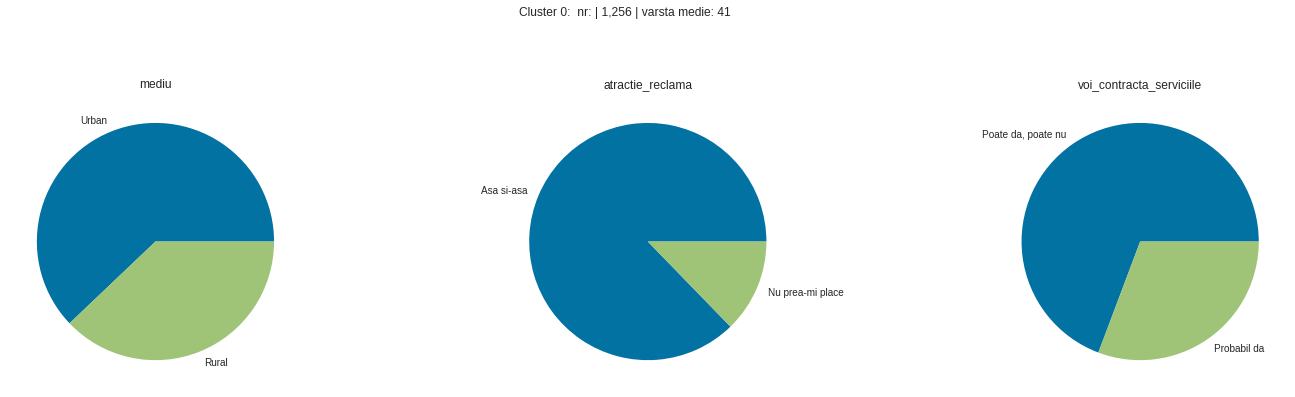

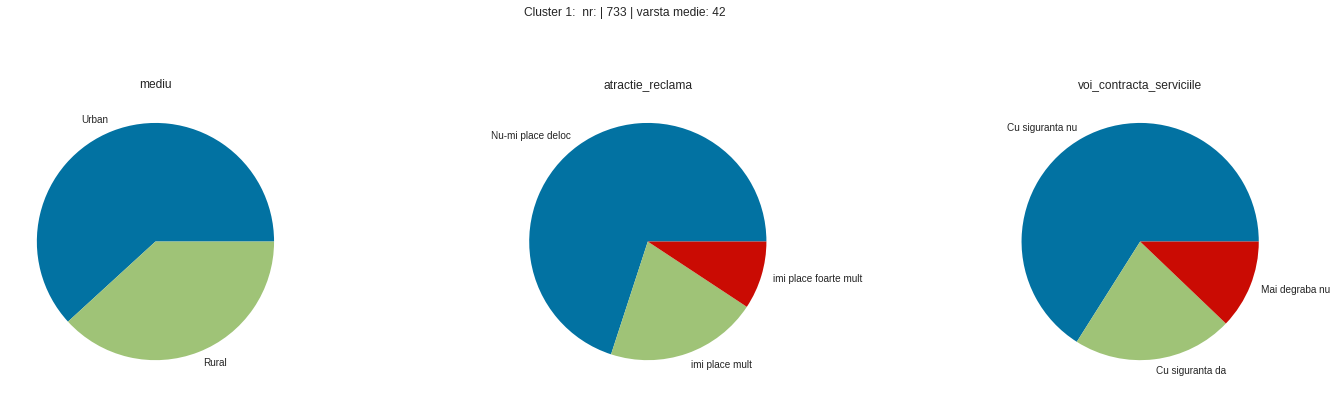

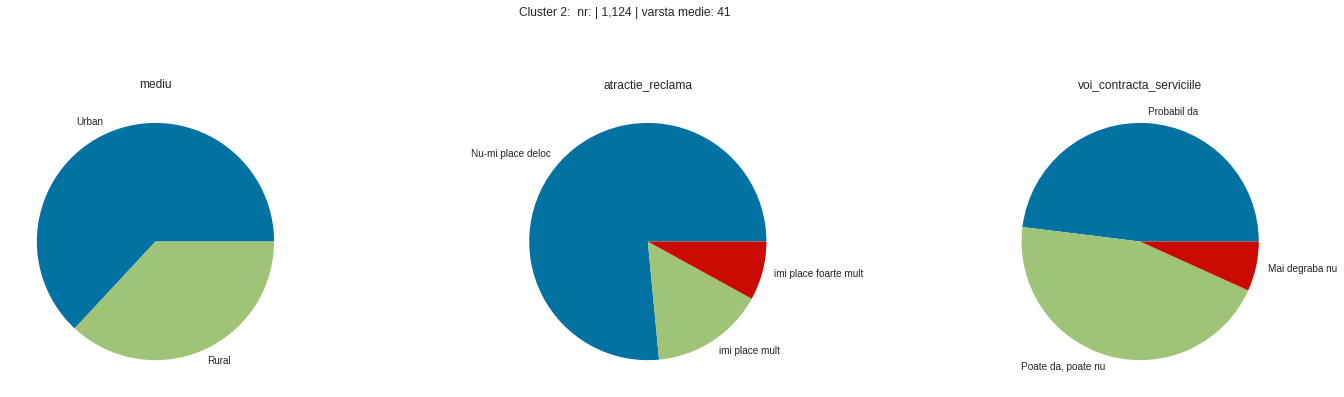

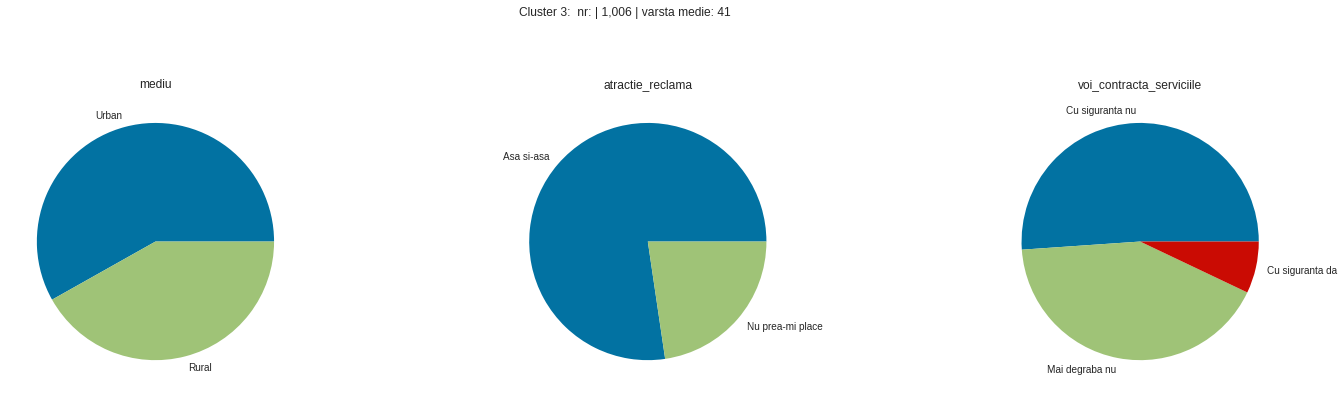

In [41]:
cluster_profile(data_kmeans_clusters).T

# C. k-Prototyping for Mixed Numerical and Categorical Variables

In [42]:
# scalarea valorilor numerice
data_kPrototype = data.copy()
col_num = list(data_kPrototype.dtypes[data_kPrototype.dtypes == "float64"].index)
if len(col_num)!=0:
    scaler = StandardScaler()
    data_kPrototype[col_num] = scaler.fit_transform(data_kPrototype[col_num])
    data_kPrototype.describe()

In [43]:
# get indices of category columns
index_category_columns = [data_kPrototype.columns.get_loc(col) for col in list(data_kPrototype.select_dtypes("object").columns)]
index_category_columns

[1, 2, 3]

In [44]:
# kPrototypes
kProto = KPrototypes(n_clusters = 4, init='Cao', n_jobs = 4)
clusters = kProto.fit_predict(data_kPrototype, categorical=index_category_columns)
kProto.cost_

3633.7983134821134

In [ ]:
# rularea kPrototypes pentru diferite valori ale lui k pentru aflarea valorii optime
cost_dict = {}
for k in tqdm(range(2,10)):
    kproto = KPrototypes(n_clusters=k, init='Cao', n_jobs=4, verbose=2)
    kproto_clusters = kproto.fit_predict(data_kPrototype, categorical=index_category_columns)
    cost_dict[k] = kproto.cost_
#afisarea costurilor pentru diferite valori ale clusterelor
print("Costurile:")
_ = [print(k,":",f'{v:.3f}') for k,v in cost_dict.items()]

#diagrama
plt.figure(figsize=[8,5])
plt.plot(cost_dict.keys(), cost_dict.values(), color="blue")
plt.title("Aflarea numarului de clustere optim")
plt.xticks(np.arange(2,10,1))
plt.xlabel("Numar de clustere K")
plt.ylabel("cost");

  0%|          | 0/8 [00:00<?, ?it/s]

Initialization method and algorithm are deterministic. Setting n_init to 1.


 12%|█▎        | 1/8 [00:18<02:11, 18.79s/it]

Best run was number 4
Initialization method and algorithm are deterministic. Setting n_init to 1.
Best run was number 6


 25%|██▌       | 2/8 [00:46<02:25, 24.20s/it]

Initialization method and algorithm are deterministic. Setting n_init to 1.
Best run was number 6


 38%|███▊      | 3/8 [01:18<02:19, 27.82s/it]

Initialization method and algorithm are deterministic. Setting n_init to 1.
Best run was number 5


 50%|█████     | 4/8 [01:58<02:09, 32.42s/it]

Initialization method and algorithm are deterministic. Setting n_init to 1.
Best run was number 9


 62%|██████▎   | 5/8 [02:52<02:00, 40.16s/it]

Initialization method and algorithm are deterministic. Setting n_init to 1.
Best run was number 9


 75%|███████▌  | 6/8 [03:39<01:25, 42.74s/it]

Initialization method and algorithm are deterministic. Setting n_init to 1.


In [ ]:
# clasa KneeLocator class determina numarul de clustere 
cost = KneeLocator(
        x=list(cost_dict.keys()), 
        y=list(cost_dict.values()), 
        S=0.1, curve="convex", direction="decreasing", online=True)
print("elbow la k =", f'{cost.elbow:.0f} clustere')

In [ ]:
data_kPrototype_clusters=data.copy()
data_kPrototype_clusters.insert(0, "Cluster", clusters)  
data_kPrototype_clusters.tail(5)

In [ ]:
# call cluster profile function
cluster_profile(data_kPrototype_clusters).T

In [ ]:
result = pd.concat([data_original, data_kPrototype_clusters], axis=1).reindex(data_original.index)
print(result)

In [ ]:
print(data)

In [ ]:
result = pd.concat([data_original, data_kPrototype_clusters], axis=1, join="inner")
print(result)